# Clustering and Topic Modeling

In this article we will explore how to cluster and topic model text data using language models. We will be playing with the `ArXiv` NLP dataset, which contains a collection of abstracts from the famous ArXiv website.

> This is a good use case since reasearch papers are often clustered and topic modeled by funders, researchers, and other stakeholders to better understand the research landscape and identify trends 😎


In [ ]:
!pip install bertopic datasets groq datamapplot

Load the ArXiv dataset from hf hub `maartengr/arxiv_nlp`

In [ ]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("billingsmoore/text-clustering-example-data")
texts = dataset['train']['text']

# Extract metadata
# abstracts = dataset["Abstracts"]
# titles = dataset["Titles"]

## Traditional pipeline for text clustering

Text clustering is a powerful technique for uncovering both familiar and hidden patterns inside text data. It provides an intuitive grasp of tasks like classification while revealing their underlying complexity, making it far more valuable than a simple exploratory data analysis tool 🥸

While numerous text clustering approaches exists; from graph-based neural architectures to centroid-driven clustering methods widely adopted pipeline has emerged, consisting of **three key stages**

**1. Transform input documents into numerical embeddings using an embedding model.**

**2. Compress the embedding dimensions through a dimensionality reduction algorithm.**

**3. Identify clusters of semantically related documents using a clustering model.**



### Embedding Documents

As you may know from now; embeddings are numerical representations of text that attempt to capture its meaning.

**Choosing embedding models optimized for semantic similarity tasks is especially important for clustering as we attempt to find groups of semantically similar documents. Fortunately, most embedding models at the time of writing focus on just that, semantic similarity 😎**


You can choose your model inside the [embedding benchmark](https://huggingface.co/spaces/mteb/leaderboard)

> Here we will chose a tiny model such as `thenlper/gte-small` for fitting our hardware

In [ ]:
from sentence_transformers import SentenceTransformer

# create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
# dimensions of the embeddings
embeddings.shape

(925, 384)

### Reducing the Dimensionality of Embeddings


Prior to clustering embeddings, we must address their high-dimensional nature. Higher dimensions lead to exponential increases in potential values across each dimension, making it progressively harder to explore all possible subspaces.

High-dimensional data poses significant challenges for most clustering algorithms, as identifying meaningful groupings becomes increasingly difficult 🤯.

Dimensionality reduction offers a solution to this problem **the idea is pretty straigh forward : compresses the dimensional space, enabling data representation with fewer dimensions while maintaining its essential characteristics.**

> ⚠️ Dimensionality reduction techniques, however, are not flawless. They do not perfectly capture high-dimensional data in a lower-dimensional representation. **Information will always be lost with this procedure. There is a balance between reducing dimensionality and keeping as much information as possible** ⚠️


We will work with the [`UMAP` model](https://huggingface.co/papers/1802.03426) for this reduction.

The `n_components` parameter determines the target dimensionality of the reduced space—in this case, 5 dimensions. Typically, selecting between 5 and 10 dimensions effectively preserves the global structure of a high dimensional dataset.

The `min_dist` parameter controls the minimum spacing between embedded points. Setting it to 0 tends to produce more compact, well defined clusters. We specify 'cosine' as the metric since Euclidean-based approaches struggle with high-dimensional datasets.

It's important to note that while setting a random_state in UMAP ensures reproducible results across different sessions, it disables parallel processing, which can significantly increase training time.

In [ ]:
from umap import UMAP

# reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Cluster the Reduced Embeddings

With dimensionally-reduced embeddings in hand, we can now identify clusters of related documents. We'll use **HDBSCAN** (Hierarchical Density-Based Spatial Clustering), which automatically determines the number of clusters and handles noise effectively.

The `min_cluster_size` parameter sets the minimum number of documents required to form a cluster. Documents that don't fit into any cluster are labeled as outliers (-1).

> If you are not familiar with DBSCAN, you can check out the article on my website [here](https://courses.dallard.tech/ml/notebooks/DBSCAN/) or if you only have 30sec go check the interactive visualization [here](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

In [ ]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7

## Inspecting the Clusters

Now that we have our clusters, (155 for instance) let's examine what they contain. We can look at individual documents within a cluster to understand what topics or themes the clustering algorithm has identified 👀

In [ ]:
import numpy as np

# inspect the first three documents in cluster 0:
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(list(texts)[index][:300] + "... \n")

The quarterback threw a perfect pass to the wide receiver.... 

The basketball bounced across the court as the players scrambled for it.... 

Football games are often played in outdoor stadiums under the open sky.... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [ ]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
# df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Cluster visualization

Now let's visualize the clusters in 2D space using matplotlib (more convinient than represents 155 dimensions 😅).

Outliers are displayed in grey, while clusters are colored distinctly to highlight the grouping structure.

> 🤔 How can we decrease the number of grey points?


(np.float64(-7.07761914730072),
 np.float64(18.106140208244323),
 np.float64(-7.94273431301117),
 np.float64(20.092005801200866))

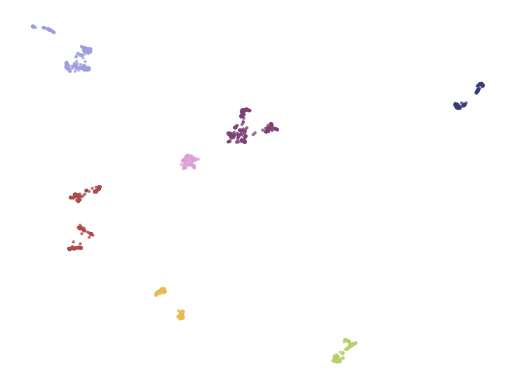

In [ ]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

## From clustering to Topic Modeling

**While clustering groups documents together, topic modeling goes a step further by extracting meaningful keywords that describe each cluster.**

> This transforms numeric clusters into interpretable topics that can be understood by humans 🧠


We will use [BERTopic](https://github.com/MaartenGr/BERTopic) to perform our topic modeling task here. BERTopic combines the three-stage clustering pipeline with an additional layer: topic representation. It uses class-based TF-IDF (c-TF-IDF) to extract the most important keywords for each cluster, creating interpretable topic descriptions.

> The framework is modular, allowing you to plug in your own embedding, dimensionality reduction, and clustering models

In [ ]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(texts, embeddings)

2025-12-17 22:53:08,166 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-17 22:53:14,406 - BERTopic - Dimensionality - Completed ✓
2025-12-17 22:53:14,412 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-17 22:53:14,502 - BERTopic - Cluster - Completed ✓
2025-12-17 22:53:14,510 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-17 22:53:14,626 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,188,0_orange_apple_and_the,"[orange, apple, and, the, for, with, to, was, ...",[The orange's juice was tart and refreshing on...
1,1,186,1_of_meditation_the_and,"[of, meditation, the, and, yoga, spiritual, in...",[Meditation helps deepen one's sense of spirit...
2,2,183,2_the_duck_its_cat,"[the, duck, its, cat, dog, it, in, of, kitten,...",[The cat's eyes gleamed in the darkness as it ...
3,3,98,3_trucks_are_car_truck,"[trucks, are, car, truck, for, the, and, cars,...",[Pickup trucks are a staple in rural areas for...
4,4,91,4_house_condo_the_has,"[house, condo, the, has, with, condos, for, an...","[The house's kitchen has a large island, perfe..."
5,5,90,5_the_basketball_team_football,"[the, basketball, team, football, game, guard,...",[The football team’s offensive line dominated ...
6,6,89,6_plants_garden_and_can,"[plants, garden, and, can, gardening, your, li...",[Gardening gloves protect your hands while wor...


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [ ]:
topic_model.get_topic(0)

[('orange', np.float64(0.07178669604999995)),
 ('apple', np.float64(0.06755271492499626)),
 ('and', np.float64(0.063122127941365)),
 ('the', np.float64(0.05515001106165237)),
 ('for', np.float64(0.045555430323769124)),
 ('with', np.float64(0.04484831126834727)),
 ('to', np.float64(0.044185403409753285)),
 ('was', np.float64(0.04416148047689172)),
 ('flavor', np.float64(0.04357024884152348)),
 ('is', np.float64(0.037928974417582355))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [ ]:
topic_model.find_topics("topic modeling")

([0, 1, 3, 2, 6],
 [np.float32(0.8178404),
  np.float32(0.8174476),
  np.float32(0.8150419),
  np.float32(0.80666465),
  np.float32(0.80363274)])

In [ ]:
# Or see how many topics exist
all_topics = topic_model.get_topics()
print(f"Total topics (including -1 for outliers): {len(all_topics)}")
print(f"Topic numbers: {list(all_topics.keys())}")


Total topics (including -1 for outliers): 7
Topic numbers: [0, 1, 2, 3, 4, 5, 6]


It returns that topic 26 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [ ]:
topic_model.get_topic(6)

[('plants', np.float64(0.13594525291063175)),
 ('garden', np.float64(0.08936653100495418)),
 ('and', np.float64(0.0841360891740298)),
 ('can', np.float64(0.08069596077131894)),
 ('gardening', np.float64(0.07126424592614877)),
 ('your', np.float64(0.06920766485269797)),
 ('like', np.float64(0.06496012729600262)),
 ('to', np.float64(0.057861899389342636)),
 ('soil', np.float64(0.053561027664477186)),
 ('for', np.float64(0.04722765412875732))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [ ]:
# Ignore because we do not have 'titles' in the case of our dataset

# topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

**Interactive visualization**

The cool tool from BERTopic is the interactive visualization of documents across topics called `visualize_documents()`. This interactive visualization shows how documents are distributed across topics in 2D space.

> Each point represents a document, colored by its assigned topic

In [ ]:
# Ignore because we do not have 'titles' in the case of our dataset
'''
# Visualize topics and documents
fig = topic_model.visualize_documents(
    list(titles),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))
'''

'\n# Visualize topics and documents\nfig = topic_model.visualize_documents(\n    list(titles),\n    reduced_embeddings=reduced_embeddings,\n    width=1200,\n    hide_annotations=True\n)\n\n# Update fonts of legend for easier visualization\nfig.update_layout(font=dict(size=16))\n'

In [ ]:
# Ignore because we do not have 'titles' in the case of our dataset

# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [ ]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [ ]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

This representation model leverages embeddings to find keywords most similar to the topic's overall semantic meaning, resulting in more coherent and representative topic descriptions.

In [ ]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(texts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,oranges | apples | fruit | flavors | orange,oranges | apples | fruit | flavors | orange
1,1,meditation | yoga | spiritual | spirituality |...,meditation | yoga | spiritual | spirituality |...
2,2,duck | dog | ducks | dogs | tail,duck | dog | ducks | dogs | tail
3,3,trucks | truck | vehicles | pickup | diesel,trucks | truck | vehicles | pickup | diesel
4,4,house | kitchen | porch | fireplace | amenities,house | kitchen | porch | fireplace | amenities


### Maximal Marginal Relevance

MMR balances relevance and diversity when selecting keywords. The `diversity` parameter (0-1) controls this trade-off: higher values produce more diverse keywords, while lower values prioritize relevance.

In [ ]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(texts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,oranges | apples | fruit | flavors | orange,orange | with | flavor | apples | cuisine
1,1,meditation | yoga | spiritual | spirituality |...,meditation | yoga | spiritual | many | pose
2,2,duck | dog | ducks | dogs | tail,the | duck | dog | kitten | feathers
3,3,trucks | truck | vehicles | pickup | diesel,trucks | the | cars | electric | pickup
4,4,house | kitchen | porch | fireplace | amenities,condos | large | views | residents | kitchen


## Text Generation


Instead of using keywords, we can leverage some Large Language Models (LLMs) to generate natural language descriptions of topics. This produces more readable and contextually rich topic labels.

### Flan-T5

For this we will use Flan-T5, a small instruction-tuned model that can generate topic descriptions based on a custom prompt. We provide representative documents and keywords as context, and the model generates a concise topic label.    

> 🤔 What is an instruction-tuned model ?   








In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(texts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


,Topic,Original,Updated
0,0,oranges | apples | fruit | flavors | orange,apple | | | |
1,1,meditation | yoga | spiritual | spirituality |...,chanting of “om” | | | |
2,2,duck | dog | ducks | dogs | tail,dog | | | |
3,3,trucks | truck | vehicles | pickup | diesel,truck | | | |
4,4,house | kitchen | porch | fireplace | amenities,Condos | | | |


In [ ]:
! export GROQ_API_KEY="your_key"

### Groq - OpenAI alternative

Like in our previous example, we will use Groq to generate our topic labels. It is a great alternative to OpenAI, cheaper and faster.

> Do not forget to set your API key as an environment variable and to not expose it to the public please !

In [ ]:
! pip install groq

#### Activity

Let's now generate our topic labels using Groq. You will do it this time 🤓

Your task is to write a function that uses the Groq API to generate better, more human-readable labels for topics discovered by BERTopic. Instead of having generic "Topic 0", "Topic 1" labels, your function will create meaningful names like "Machine Learning Applications" or "Climate Change Research."

The function should look like this :

```python

def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    # Your code here
    pass
```

# Function Assignment: `update_topics_with_groq`

## Overview
Your task is to write a function that uses the Groq API to generate better, more human-readable labels for topics discovered by BERTopic. Instead of having generic "Topic 0", "Topic 1" labels, your function will create meaningful names like "Machine Learning Applications" or "Climate Change Research."

## Function Signature
```python
def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    # Your code here
```

## What Your Function Must Do

### Step 1: Extract Current Topics
- Retrieve all topics from the `topic_model` using the `.get_topics()` method
- Create an empty dictionary called `updated_labels` to store your new topic names

### Step 2: Create Your Prompt Template

Design a prompt string that includes:

- A section showing representative documents from the topic
- A section showing the top keywords describing the topic
- Clear instructions asking the LLM to extract a short, concise topic label
- Format instruction: `topic: <short topic label>`

### Step 3: Loop Through Each Topic

For each topic in your topics dictionary:

- **Skip the outlier topic** (topic_id == -1)
- Get the top 5 representative documents for this topic using `.get_representative_docs(topic_id)`
- Join these documents with newlines for readability
- Extract the top 10 keywords from the topic (they come as word-score pairs, you only need the words)
- Format the keywords as a comma-separated string

### Step 4: Call the Groq API

For each topic, make an API call with the following requirements:

Implement retry logic (maximum 3 attempts):

- Use the `client.chat.completions.create()` method
- Set up two messages:
  - **System message**: Tell the AI it's a helpful assistant that creates concise topic labels
  - **User message**: Your formatted prompt with documents and keywords filled in
- Use `temperature=0` for consistent results
- Set `max_tokens=500` as the limit

**Handle the response**:

- Extract the text content from `response.choices[0].message.content`
- Strip whitespace
- Remove the "topic: " prefix if the LLM included it (case-insensitive check)
- Store the cleaned label in your `updated_labels` dictionary with the topic_id as key

### Step 5: Error Handling & Rate Limiting

- Add a 0.5 to 1 second delay after each successful API call to respect rate limits with the `random` module
- If an API call fails:
  - Retry up to 3 times
  - Use **exponential backoff**: wait 2^attempt seconds (1s, 2s, 4s)
  - Print retry messages to inform the user
  - If all retries fail, use a fallback label: `f"Topic {topic_id}"`

### Step 6: Update and Return

- Apply all your new labels to the topic model using `.set_topic_labels(updated_labels)`
- Return the updated topic_model



You should see an output like the dataframe below


In [ ]:
from groq import Groq
import os
from google.colab import userdata
userdata.get('GROQ_API_KEY')

from dotenv import load_dotenv
import time

load_dotenv()

import time
import random
from groq import Groq

def update_topics_with_groq(topic_model,documents,api_key="your_key", model="meta-llama/llama-4-scout-17b-16e-instruct"):
    """
    Update topic labels in a BERTopic model using Groq API for intelligent naming.

    Args:
        topic_model: Fitted BERTopic model
        documents: Original documents used to fit the model
        model: Groq model to use for label generation

    Returns:
        Updated topic_model with new labels
    """
    # Initialize Groq client
    client = Groq()

    # Step 1: Extract current topics
    topics = topic_model.get_topics()
    updated_labels = {}

    # Step 2: Create prompt template
    prompt_template = """Based on the following representative documents and keywords, extract a short, concise topic label (2-4 words maximum).

Representative Documents:
{documents}

Top Keywords:
{keywords}

Provide only the topic label in the format: topic: <short topic label>"""

    # Step 3: Loop through each topic
    for topic_id in topics.keys():
        # Skip outlier topic
        if topic_id == -1:
            continue

        print(f"Processing topic {topic_id}...")

        # Get top 5 representative documents
        rep_docs = topic_model.get_representative_docs(topic_id)[:5]
        docs_text = "\n".join(rep_docs)

        # Extract top 10 keywords (only the words, not scores)
        topic_keywords = topics[topic_id][:10]
        keywords = ", ".join([word for word, score in topic_keywords])

        # Format the prompt
        formatted_prompt = prompt_template.format(
            documents=docs_text,
            keywords=keywords
        )

        # Step 4: Call the Groq API with retry logic
        max_retries = 3
        success = False

        for attempt in range(max_retries):
            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": "You are a helpful assistant that creates concise topic labels based on documents and keywords. Always respond with just the topic label."
                        },
                        {
                            "role": "user",
                            "content": formatted_prompt
                        }
                    ],
                    temperature=0,
                    max_tokens=500
                )

                # Extract and clean the response
                label = response.choices[0].message.content.strip()

                # Remove "topic: " prefix if present (case-insensitive)
                if label.lower().startswith("topic:"):
                    label = label[6:].strip()

                # Store the label
                updated_labels[topic_id] = label
                print(f"  → Generated label: {label}")

                success = True

                # Step 5: Rate limiting - delay after successful call
                time.sleep(random.uniform(0.5, 1.0))
                break

            except Exception as e:
                if attempt < max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f"  ⚠ Retry {attempt + 1}/{max_retries} after {wait_time}s (Error: {str(e)})")
                    time.sleep(wait_time)
                else:
                    print(f"  ✗ All retries failed for topic {topic_id}, using fallback label")

        # Use fallback label if all retries failed
        if not success:
            updated_labels[topic_id] = f"Topic {topic_id}"

    # Step 6: Update and return
    topic_model.set_topic_labels(updated_labels)
    print(f"\n✓ Successfully updated {len(updated_labels)} topic labels")

    return topic_model

update_topics_with_groq(topic_model, texts)


Processing topic 0...
  → Generated label: Fruit Flavors
Processing topic 1...
  → Generated label: Meditation Spirituality
Processing topic 2...
  → Generated label: Animals at Home
Processing topic 3...
  → Generated label: Types of Trucks
Processing topic 4...
  → Generated label: Home Features
Processing topic 5...
  → Generated label: Sports Highlights
Processing topic 6...
  → Generated label: Gardening Tips

✓ Successfully updated 7 topic labels


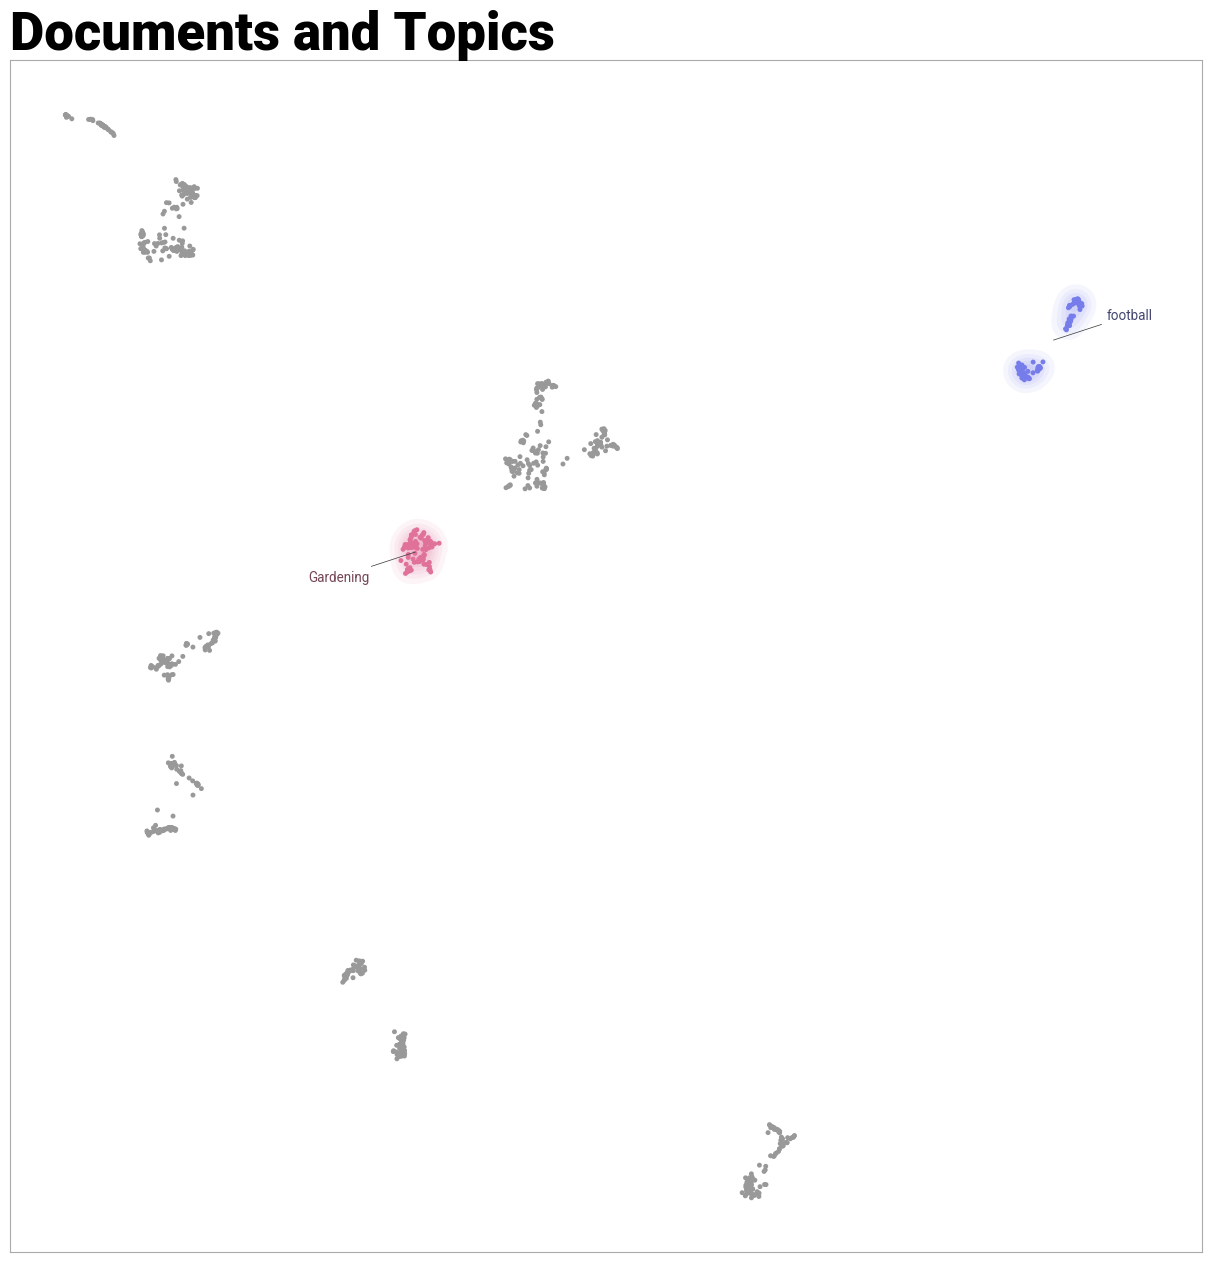

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    topics=list(range(5,20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    height=1200,
)
plt.savefig("datamapplot.png")


## The classico classic : word cloud

Make sure to pip install `wordcloud` first in order to run this code


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [ ]:
! pip install wordcloud

In [ ]:
topic_model.update_topics(texts, top_n_words=500)

2025-12-17 23:25:02,150 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Then, we can run the following code to generate the wordcloud for our topic modeling task :

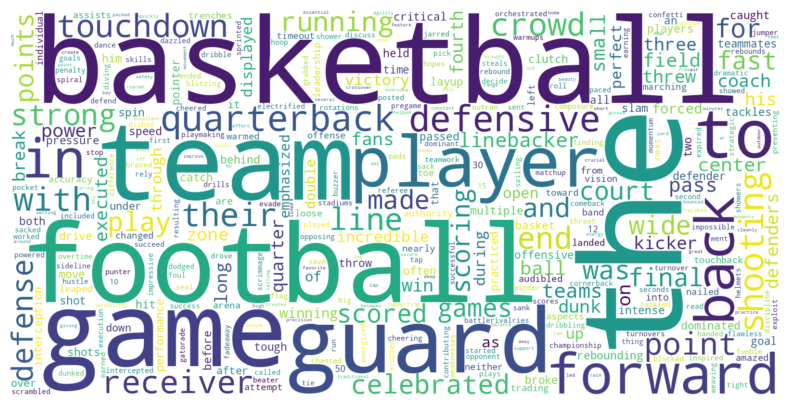

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=5)